In [40]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
from utils import *
import missingno as msno
from sklearn import preprocessing, model_selection, feature_selection, linear_model, svm, tree, ensemble, decomposition, metrics, neighbors

In [2]:
def find_correlation(df, thresh=0.9):
    """
    Given a numeric pd.DataFrame, this will find highly correlated features,
    and return a list of features to remove

    params:
    - df : pd.DataFrame
    - thresh : correlation threshold, will remove one of pairs of features with
               a correlation greater than this value
    """
    
    corrMatrix = df.corr()
    corrMatrix.loc[:,:] =  np.tril(corrMatrix, k=-1)

    already_in = set()
    result = []

    for col in corrMatrix:
        perfect_corr = corrMatrix[col][corrMatrix[col] > thresh].index.tolist()
        if perfect_corr and col not in already_in:
            already_in.update(set(perfect_corr))
            perfect_corr.append(col)
            result.append(perfect_corr)


    select_nested = [f[1:] for f in result]
    select_flat = [i for j in select_nested for i in j]
    return select_flat

# Data Loading and Cleaning

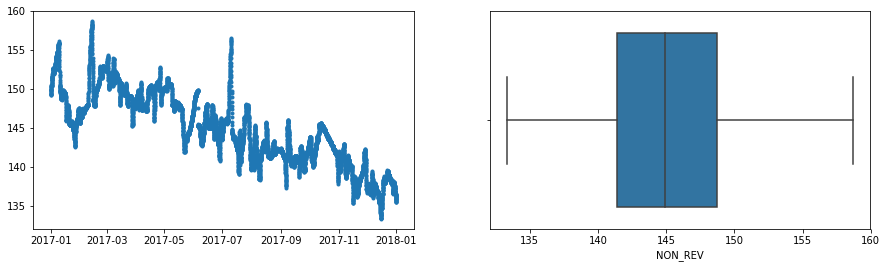

In [3]:
data = pd.read_excel('tags_for_Paul.xlsx')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
ax[0].plot(data.index, data.NON_REV,'C0.')
sns.boxplot(data.NON_REV, ax=ax[1])

In [4]:
msno.matrix(data)

In [5]:
desc = data.describe().T

#remove tags that are constant throughout the year
constant_tags = desc[desc['std'] == 0].index
data = data.drop(columns = constant_tags)

#remove tags with less than 7000 entries
low_entries = desc[desc['count']< 7000].index
data = data.drop(columns = low_entries)

#remove empty SP rows (white band of rows in the plot above)
data.dropna(subset=['AC5060BA.SP'], inplace=True)

full_tags = desc[desc['count'] == 8761].index
incomp_tags = desc[desc['count'] != 8761].index
high_std = desc[desc['std'] > 100].index
print('Number of constant tags {}, number of incomplete tags {}'.format(len(constant_tags), len(low_entries)))
print(data.shape)

Number of constant tags 17, number of incomplete tags 17
(8569, 161)


In [6]:
no_nan = sum(data.isnull().sum())
print('Number of missing values', no_nan)
data = data.fillna(method='ffill', )
no_nan = sum(data.isnull().sum())
print('Number of missing values', no_nan)

Number of missing values 1442
Number of missing values 0


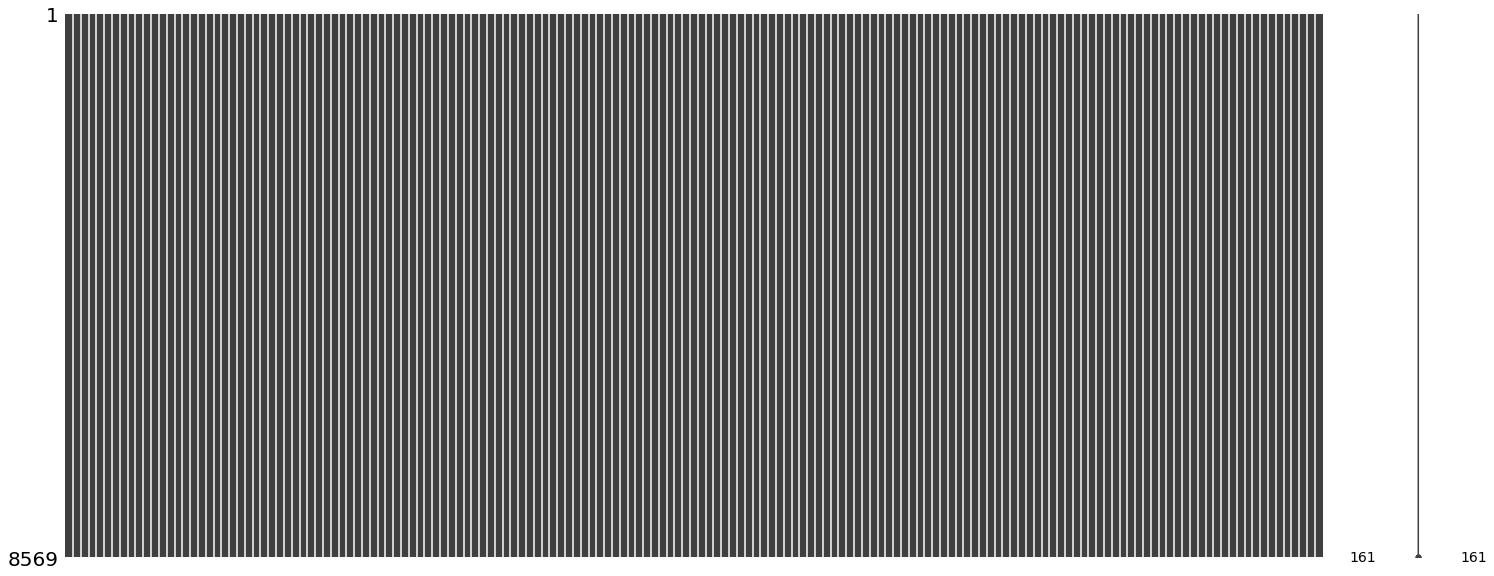

In [7]:
msno.matrix(data)

In [8]:
np.set_printoptions(precision=2, suppress=True)
features = data.iloc[:,:-3]
labels = data.NON_REV
rank = np.linalg.matrix_rank(features)
u, s, vh = np.linalg.svd(features)
print(features.shape, rank)
print(vh[-1])
features = features.drop(columns=['F5507_Spec_Grav.1'])

(8569, 158) 157
[ 0.    0.    0.   -0.   -0.    0.71 -0.    0.    0.    0.    0.    0.
  0.   -0.   -0.    0.   -0.    0.    0.   -0.   -0.    0.    0.   -0.
  0.   -0.    0.   -0.    0.    0.   -0.    0.   -0.   -0.    0.    0.
  0.    0.    0.    0.   -0.    0.   -0.   -0.    0.    0.    0.   -0.
 -0.   -0.    0.   -0.    0.    0.   -0.    0.   -0.    0.    0.    0.
  0.    0.    0.    0.   -0.   -0.   -0.    0.   -0.   -0.    0.   -0.
  0.    0.    0.    0.   -0.   -0.    0.    0.    0.   -0.    0.   -0.
 -0.   -0.    0.   -0.    0.    0.   -0.    0.    0.   -0.    0.   -0.
  0.   -0.   -0.   -0.71 -0.   -0.    0.    0.    0.    0.   -0.   -0.
 -0.    0.   -0.   -0.   -0.    0.    0.    0.   -0.   -0.   -0.   -0.
 -0.    0.    0.   -0.    0.   -0.   -0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.   -0.   -0.    0.   -0.    0.    0.   -0.
  0.   -0.   -0.   -0.   -0.   -0.    0.   -0.    0.    0.   -0.   -0.
 -0.   -0.  ]


In [9]:
corr_mat = features.corr()

plt.subplots(figsize=(12, 10))
mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_mat, mask=mask, cmap = 'RdBu_r')

In [10]:
thresh = 0.85
inv_mask = ~mask.astype(np.bool)
corr_df = corr_mat.where(inv_mask.astype(np.bool))
corr_df = corr_df[(corr_df>thresh) | (corr_df<-thresh)]

plt.subplots(figsize=(12, 10))
sns.heatmap(corr_df, mask=mask, cmap = 'RdBu_r',vmin=-1,vmax=1)
corr_col = find_correlation(features, thresh)
corr_col

['F5507_Viscosity',
 'AC5166BA.SP',
 'F5507_SAQ',
 'F5507_TAQ',
 'CE5875/1_AQ',
 'V5878_AQ',
 'LDC5507B.SP',
 'F5507_AA_DP',
 'CE5875/1_C_THQ',
 'CE5875/1_Sum_C_T_THQ',
 'V5878_C_THQ',
 'V5878_Sum_C_T_THQ',
 'F5507_C_THQ',
 'F5507_DBC',
 'F5507_TAQ',
 'CE5875/1_AQ',
 'V5878_AQ',
 'F5507_Naphthalene',
 'F5507_OX',
 'F5507_Part Coeff ',
 'CE5875/1_Qt ',
 'F5507_Qc ',
 'F5507_Qc/Res ',
 'CE5875/1_Qu ',
 'F5507_Qu ',
 'F5507_Residue',
 'V5878_TDO',
 'F5507_TDO',
 'F5507_TDQ',
 'F5507_THHQ',
 'F5507_TQ',
 'CE5875/1_Qc ',
 'CE5855/1_QLoss',
 'CE5855/3 Carbon',
 'pH of Aq. ex. CE5855/1']

In [11]:
features = features.drop(columns=corr_col)

In [12]:
F5507_cols = [c for c in features.columns if 'F5507' in c]
features = features.drop(columns=F5507_cols)

# Training

In [13]:
no_rows = features.shape[0]
twenty_p = int(np.round(no_rows*0.2,0))
full_range = np.arange(0,no_rows)
np.random.seed(8)
np.random.shuffle(full_range)
holdout_no = np.sort(full_range[:twenty_p])
train_no = np.sort(full_range[twenty_p:])

features_train = features.iloc[train_no,:]
labels_train = labels[train_no]
features_holdout = features.iloc[holdout_no,:]
labels_holdout = labels[holdout_no]

print('Number of features', features.shape[1], 
      ', number of training samples', features_train.shape[0],
     ', number of samples in holdout set', features_holdout.shape[0])

Number of features 100 , number of training samples 6855 , number of samples in holdout set 1714


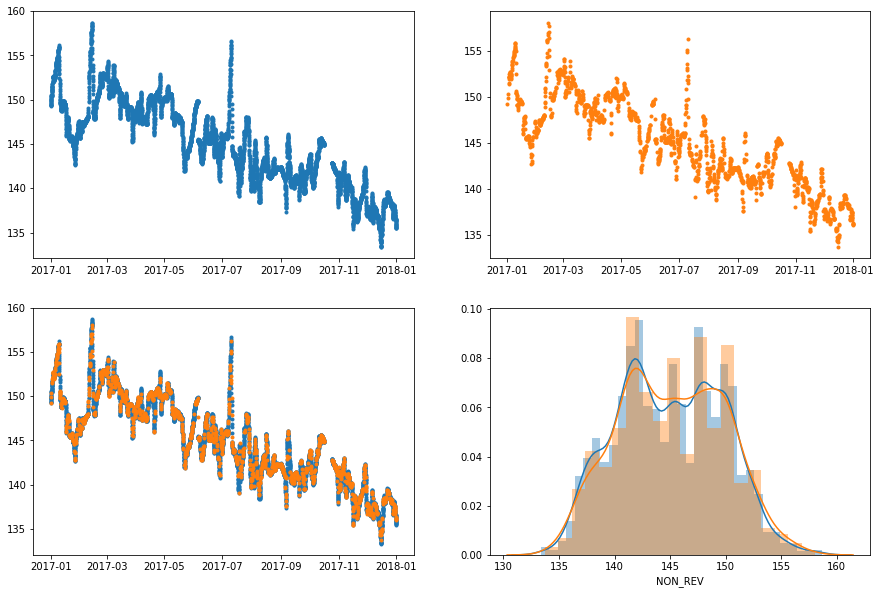

In [14]:
fig, ax = plt.subplots(figsize=(15,10), nrows=2, ncols=2)
ax=ax.ravel()
ax[0].plot(features.index[train_no], data.NON_REV[train_no],'.C0', label='training')
ax[1].plot(features.index[holdout_no], data.NON_REV[holdout_no],'.C1', label='testing')
ax[2].plot(features.index[train_no], data.NON_REV[train_no],'.C0', label='training')
ax[2].plot(features.index[holdout_no], data.NON_REV[holdout_no],'.C1', label='testing')
sns.distplot(labels_train, ax=ax[3])
sns.distplot(labels_holdout, ax=ax[3])

In [15]:
# Kolmogorov-Smirnov null hypothesis: 2 independent samples are drawn from the same continuous distribution
from scipy import stats
stats.ks_2samp(labels_train.values, labels_holdout.values)
# statistic is small we cannot reject the null hypothesis

Ks_2sampResult(statistic=0.026722311729805687, pvalue=0.27780737702208835)

In [16]:
feat_df = features
ss = preprocessing.StandardScaler()
ss.fit(features_train)
features_train = ss.transform(features_train)
features_holdout = ss.transform(features_holdout)

In [17]:
# %%time
# parameters = {'loss':('ls', 'lad', 'huber', 'quantile'),
#               'learning_rate':(0.1, 0.5, 0.9),
#               'n_estimators':(10, 100, 500, 1000),
#               'min_samples_split':(2, 5, 10 ,100),
#               'min_samples_leaf':(1, 2, 5, 10),
#               'max_depth':(1, 3, 5, 10, 100),
#               'max_features':('sqrt','log2','auto'),}
# GBRT = ensemble.GradientBoostingRegressor()

# clf = model_selection.RandomizedSearchCV(GBRT, parameters, n_jobs=4, n_iter=100, cv = 5)

# clf.fit(features_train, labels_train)
# print(clf.best_params_, clf.best_score_)
# {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 10, 
#  'loss': 'ls', 'learning_rate': 0.1}

In [18]:
# %%time
# parameters = {'n_estimators':(10, 100, 500, 1000),
#               'max_depth':(1, 3, 5, 10, 100),
#               'min_samples_split':(2, 5, 10 ,100),
#               'min_samples_leaf':(1, 2, 5, 10),
#               'max_features':('sqrt','log2','auto')}
# RF = ensemble.RandomForestRegressor()

# clf = model_selection.RandomizedSearchCV(RF, parameters, n_jobs=4, n_iter=100, cv = 5)

# clf.fit(features_train, labels_train)
# print(clf.best_params_, clf.best_score_)
# {'n_estimators': 10, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': 'log2', 'max_depth': 5}

In [19]:
# clf = ensemble.GradientBoostingRegressor(n_estimators=100, min_samples_split=5, min_samples_leaf=5, random_state=42,
#                                          max_features='sqrt', max_depth=10, loss='ls', learning_rate=0.1)
clf = ensemble.RandomForestRegressor(n_estimators=10, min_samples_split=5, min_samples_leaf=10, max_features='log2',
                                     max_depth=5, random_state=42)
clf.fit(features_train, labels_train)
algo_score = clf.score(features_holdout, labels_holdout)
print('Model score {:.2f}'.format(np.mean(algo_score)))

Model score 0.93


Variance explained by looking at the top 10 tags 0.69


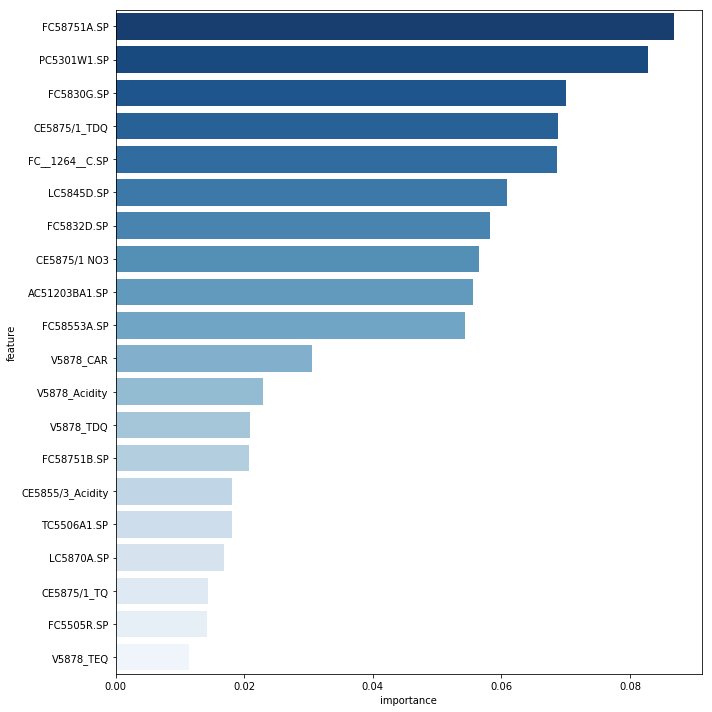

In [20]:
feat_importance = clf.feature_importances_
importance_df = pd.DataFrame({'feature':feat_df.columns, 
                              'importance':feat_importance}).sort_values(by='importance', ascending=False)

plt.subplots(figsize=(10, 10))
sns.barplot('importance','feature', data=importance_df[:20], color='C0', palette='Blues_r')
plt.tight_layout()

print('Variance explained by looking at the top 10 tags {:.2f}'.format(importance_df.iloc[:11,1:].sum()[0]))

In [27]:
## feat_sel_algo = ensemble.GradientBoostingRegressor(n_estimators=100, min_samples_split=5, min_samples_leaf=5, random_state=42,
#                                          max_features='sqrt', max_depth=10, loss='ls', learning_rate=0.1)
feat_sel_algo = ensemble.RandomForestRegressor(n_estimators=10, min_samples_split=5, min_samples_leaf=10,
                                               max_features = 'log2', max_depth=5, random_state=42)

In [31]:
## feat_sel_algo = ensemble.GradientBoostingRegressor(n_estimators=100, min_samples_split=5, min_samples_leaf=5, random_state=42,
#                                          max_features='sqrt', max_depth=10, loss='ls', learning_rate=0.1)
feat_sel_algo = ensemble.RandomForestRegressor(n_estimators=10, min_samples_split=5, min_samples_leaf=10,
                                               max_features = 'log2', max_depth=5, random_state=42)
# sfm = feature_selection.SelectFromModel(feat_sel_algo,max_features=10)
sfm = feature_selection.SelectFromModel(feat_sel_algo)
sfm.fit(features_train, labels_train)

used_feat_sfm = set(features.iloc[:,sfm.get_support()].columns.tolist())
trash_feat_sfm = set(features.columns.tolist())-used_feat_sfm

print(len(used_feat_sfm), used_feat_sfm)

20 {'V5878_CAR', 'FC58751B.SP', 'FC5832D.SP', 'LC5870A.SP', 'FC58553A.SP', 'CE5855/3_Acidity', 'V5878_TDQ', 'PC5301W1.SP', 'FC58751A.SP', 'V5878_Acidity', 'FC__1264__C.SP', 'CE5875/1_TDQ', 'CE5875/1_TQ', 'V5878_TEQ', 'AC51203BA1.SP', 'CE5875/1 NO3', 'FC5505R.SP', 'LC5845D.SP', 'FC5830G.SP', 'TC5506A1.SP'}


In [32]:
print(len(trash_feat_sfm), trash_feat_sfm)

80 {'PC5301AN.SP', 'CE5875/1_TEQ', 'Molar Ratio SP R-1201/2', 'PC5301W2.SP', 'LC5724A.SP', 'FC5505F.SP', 'CE5875/1_T_THQ', 'LC51203A.SP', 'LC5721B.SP', 'CE5855/1_QLoss Form', 'AT__1201_1RH_SP.PV', 'AT__1201_2RH_SP.PV', 'FC57903B.SP', 'LC5420F.SP', 'PC5845B.SP', 'FC58751C.SP', 'CE5855/3_acid salts', 'CE5875/1_TDO', 'TC5850A.SP', 'LC54703A.SP', 'PC5710P.SP', 'LDC5505B.SP', 'CE5875/1_TAO+ATHQtr+x', 'FC5505A.SP', 'LC5505T.SP', 'CE5875/1_THHQ', 'FC5301K.SP', 'FC57903A2.SP', 'FC5505E.SP', 'V5878_T_THQ', 'TC5832E.SP', 'CE5875/1 Carbon', 'FC57902B.SP', 'FC5870D.SP', 'FC5412A.SP', 'FC5505D.SP', 'CE5855/3_QLoss Form', 'V5878_AA_DP', 'FC5060D.SP', 'Molar Ratio SP R-1201/1', 'pH of Aq. ex. CE5875/1', 'LC5301X.SP', 'FC5420D.SP', 'LC5718B.SP', 'V5878_Qu ', 'CE5855/3_Hopkins_Water', 'pH of Aq. ex. CE5855/3', 'TC5412C.SP', 'FC51203D.SP', 'LC5878A.SP', 'PC5416N2.SP', 'PC5420K.SP', 'CE5875/1_AA_DP', 'FC58551F.SP', 'LC58623A.SP', 'FC5301R.SP', 'FC5710F.SP', 'FC5830C.SP', 'FC5832F.SP', 'FC5454A.SP', 'PC54

# Final Model

In [33]:
# clf = ensemble.GradientBoostingRegressor(n_estimators=100, min_samples_split=5, min_samples_leaf=5, random_state=42,
#                                          max_features='sqrt', max_depth=10, loss='ls', learning_rate=0.1)
clf = ensemble.RandomForestRegressor(n_estimators=10, min_samples_split=5, min_samples_leaf=10, max_features='log2',
                                     max_depth=5)
features_model =  sfm.transform(features)
ss = preprocessing.StandardScaler()
ss.fit(features_model)
features_model = ss.transform(features_model)
clf.fit(features_model, labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [41]:
fig, ax = plt.subplots(figsize=(15,20), nrows=5, ncols=2)
ax=ax.ravel()
i=0
for feat in used_feat_sfm:
    if '.SP' not in feat:
        sns.lineplot(data.index, data[feat], ax = ax[i])
        i+=1

AttributeError: module 'seaborn' has no attribute 'lineplot'

In [42]:
from seaborn import lineplot

ImportError: cannot import name 'lineplot'